## Executive Summary

This notebook explores the modeling of daily stock excess growth rates using Hidden Markov Models (HMMs). The analysis proceeds in three main stages:
1.  A standard HMM is built from historical in-sample data.
2.  This model is then tested against well-known "stylized facts" of financial returns, revealing its strengths (capturing return distributions) and weaknesses (failing to capture volatility clustering).
3.  To address these weaknesses, a modified HMM that incorporates price jumps is introduced and analyzed, demonstrating its improved ability to replicate the observed market dynamics.

 # Build a Hidden Markov Model of Daily Stock Excess Growth Rate
We are constructing an Observable Markov Model (OMM) of the excess growth rate of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
R_{ij} \equiv \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate. In this work, we build a model of daily return.

## Model
Describe the day-to-day variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix, i.e., $t_{ij}\in\mathbf{T}$ is the probability of moving from hidden state $i$ to hidden state $j$ in the next time step, and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Objectives
- **Task 1:** Characterize the continuous distribution of returns using MLE and MCMC, then discretize this distribution to build a Hidden Markov Model (HMM).
- **Task 2:** Simulate the standard HMM and analyze its ability to reproduce key stylized facts of financial returns, particularly volatility clustering.
- **Task 3:** Introduce and analyze an HMM with jumps to see if it improves upon the standard model's weaknesses.
- **Task 4:** Save the final model artifacts for future use.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [1]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.

Let's start by setting some constant values.

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 100; # number of potential futures should we look at
blue_color = colorant"rgb(68,152,242)";
ticker = "MSFT"; # This is the ticker we want to explore

# palette -
my_color_palette = Dict{Int64,RGB}();
my_color_palette[0] = colorant"#e5e5e5";
my_color_palette[1] = colorant"#ff7d00";
my_color_palette[2] = colorant"#14213d";
my_color_palette[3] = colorant"#ffecd1";
my_color_palette[4] = colorant"rgb(49,52,58)";
my_color_palette[5] = colorant"#c0d6df";
my_color_palette[6] = colorant"#000000";

### Load and clean the historical data

We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyPortfolioDataSet()` function:

In [3]:
original_dataset = MyPortfolioDataSet() |> x->x["train_dataset"]

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 2515×8 DataFrame…
  "CTAS" => 2515×8 DataFrame…
  "HSIC" => 2515×8 DataFrame…
  "KIM"  => 2515×8 DataFrame…
  "PLD"  => 2515×8 DataFrame…
  "IEX"  => 2515×8 DataFrame…
  "BAC"  => 2515×8 DataFrame…
  "CBOE" => 2515×8 DataFrame…
  "EXR"  => 2515×8 DataFrame…
  "NCLH" => 2515×8 DataFrame…
  "CVS"  => 2515×8 DataFrame…
  "DRI"  => 2515×8 DataFrame…
  "DTE"  => 2515×8 DataFrame…
  "ZION" => 2515×8 DataFrame…
  "AVY"  => 2515×8 DataFrame…
  "EW"   => 2515×8 DataFrame…
  "EA"   => 2515×8 DataFrame…
  "NWSA" => 2515×8 DataFrame…
  "CAG"  => 2515×8 DataFrame…
  "GILD" => 2515×8 DataFrame…
  "FCX"  => 2515×8 DataFrame…
  "GPC"  => 2515×8 DataFrame…
  "UNP"  => 2515×8 DataFrame…
  "CDW"  => 2515×8 DataFrame…
  "SBUX" => 2515×8 DataFrame…
  ⋮      => ⋮

In [4]:
original_dataset["AAPL"]

2515×8 DataFrame
  Row │ volume     volume_weighted_average_price  open      close     high     ⋯
      │ Float64    Float64                        Float64   Float64   Float64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 3.93215e8                        19.4749   19.745    19.3207   19.775  ⋯
    2 │ 4.13437e8                        19.3213   19.1946   19.4261   19.5286
    3 │ 3.17731e8                        19.3329   19.44     19.2871   19.4986
    4 │ 2.58747e8                        19.4038   19.2432   19.4093   19.4843
    5 │ 2.79621e8                        19.2943   19.5286   19.1614   19.5307 ⋯
    6 │ 3.05283e8                        19.0659   19.2796   19.0336   19.3143
    7 │ 3.79443e8                        19.1801   18.9254   19.1332   19.375
    8 │ 3.34937e8                        19.4033   19.2221   19.5139   19.5261
    9 │ 3.9389e8                         19.9105   19.7686   19.9057   20.0071 ⋯
   10 │ 2.29885e8                        19.8115   19.8179   19.7946   19.8875
   11 │ 4.33704e8                        19.4976   19.6957   19.3096   19.7168
  ⋮   │     ⋮                    ⋮                   ⋮         ⋮         ⋮     ⋱
 2506 │ 1.27388e8                       197.56    197.53    197.57    198.4
 2507 │ 5.57519e7                       195.625   196.09    195.89    196.63   ⋯
 2508 │ 4.07141e7                       196.528   196.16    196.94    196.95
 2509 │ 5.22428e7                       196.142   196.9     194.83    197.68
 2510 │ 4.64825e7                       194.743   196.1     194.68    197.08
 2511 │ 3.71496e7                       194.101   195.18    193.6     195.41   ⋯
 2512 │ 2.89193e7                       193.171   193.61    193.05    193.89
 2513 │ 4.80877e7                       192.568   192.49    193.15    193.5
 2514 │ 3.40499e7                       193.922   194.14    193.58    194.66
 2515 │ 4.26721e7                       192.576   193.9     192.53    194.4    ⋯
                                                 3 columns and 2494 rows omitted

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of traditional days. First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [5]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

2515

Then, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [6]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [7]:
list_of_all_tickers = keys(dataset) |> collect |> x->sort(x)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [8]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers,
    Δt = Δt, risk_free_rate = risk_free_rate)

2514×424 Matrix{Float64}:
 -0.919654   6.23895   -2.91307    …  -0.797491   0.203794  -1.04737
  2.77416    1.02939    1.35029        2.09622   -0.84489    0.944368
  3.27095    0.813497  -0.036732       0.067777   1.1489    -2.62354
  0.604325  17.2178     1.65005        0.232616   3.1172    -0.410328
  1.77399    2.53751    3.27714        0.579577  -2.2108     4.36099
  0.57173   -4.00594   -0.83488    …  -0.904839  -1.95187   -3.15834
  2.81861   -0.525851   4.80363        1.7236    -1.81895   -1.1317
  2.00461    0.971404   1.86599        1.63387    4.40774   -0.179919
  1.27079    1.63203    0.0651592     -1.54918   -2.17906    1.39574
  1.17806    6.08747    0.890478      -1.57412    2.83574   -1.47836
 -0.479768   4.82799    0.96564    …  -0.363361   9.46617   -3.05083
  1.32071    3.57107   -2.38986        0.668513   4.48013    0.298431
 -4.78114    1.34375   -3.05834       -2.19455   -6.69117    1.36402
  ⋮                                ⋱                        
  6.83722   -

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _in-sample_ data.

In [9]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i]

2514-element Vector{Float64}:
 -4.26777936640243
  0.5248340563621038
 -3.6612108778419428
 -1.7297165451244294
  2.5404649183693553
 -4.7823310366623515
  1.705362385004079
  7.252325966998464
  0.3247719057534725
 -0.9765063207980047
 -1.353063610283087
 -2.0333129900103137
  0.29202762967637075
  ⋮
  1.0033149840048643
 -4.837224705058511
  1.893626311621891
  1.067393629778941
  0.3105603076331652
  0.5047455866858552
 -0.5262689699524659
  1.3436254295254604
  0.16161955552257318
 -0.6624500635455907
  1.07025144996936
  0.23126659236469924

## Task 1: Characterizing and Discretizing the Return Distribution
### Methodology: Building the Model from Data

To construct the HMM, we first need to define its components from the historical returns data (`Rᵢ`):

1.  **States:** The continuous range of daily returns is discretized into a finite number of states. Each state represents a specific market condition, from significant losses (State 1) to significant gains (State N). We define these states by calculating the quantiles of the historical return distribution.

2.  **Transition Matrix:** The probability of moving from one state to another on the next day is estimated by observing the frequency of these transitions in the historical data.

3.  **Emission Probabilities:** In this model, the emissions are deterministic. Being in a certain state means the return is within the predefined quantile range for that state.

First, consider the states $\mathcal{S}$. Suppose we number the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between).
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`).

In [10]:
number_of_states = 80; # specify a value here, too many states or too little states would impact the model performance. 80 should provide somewhat fair granuality 
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [11]:
E = diagm(ones(number_of_states))

80×80 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

### Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable.

In [12]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

2514-element Vector{Float64}:
 -4.26777936640243
  0.5248340563621038
 -3.6612108778419428
 -1.7297165451244294
  2.5404649183693553
 -4.7823310366623515
  1.705362385004079
  7.252325966998464
  0.3247719057534725
 -0.9765063207980047
 -1.353063610283087
 -2.0333129900103137
  0.29202762967637075
  ⋮
  1.0033149840048643
 -4.837224705058511
  1.893626311621891
  1.067393629778941
  0.3105603076331652
  0.5047455866858552
 -0.5262689699524659
  1.3436254295254604
  0.16161955552257318
 -0.6624500635455907
  1.07025144996936
  0.23126659236469924

### 1a. Analyzing the Underlying Continuous Distribution

Before building our discrete-state HMM, we first seek to understand the underlying continuous probability distribution of the daily excess returns. A key part of modeling is choosing a distribution that accurately captures the stylized facts of the data, such as **"fat tails"** (a higher probability of extreme events than a normal distribution would suggest).

In this section, we will:
1.  Compare two candidate distributions: the **Laplace distribution** and the **Student's t-distribution**.
2.  Compare two different methodologies for fitting these distributions: **Maximum Likelihood Estimation (MLE)** and the more robust **Markov Chain Monte Carlo (MCMC)**.

First, we use our generic MCMC function to fit a **Student's t-distribution** to the return data. This is our primary candidate for a model that can capture fat tails. The output will be a `chain` object containing the full posterior distributions for the model's parameters: mean (`μ`), volatility (`σ`), and degrees-of-freedom (`ν`).

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


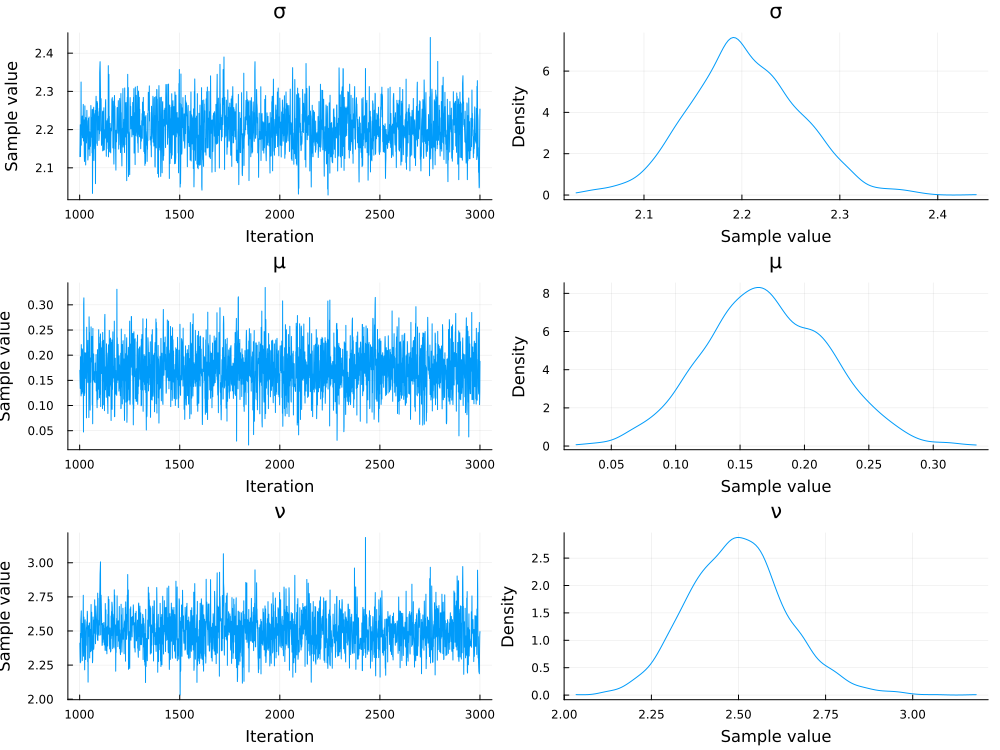

In [13]:
# To learn the Student's t-distribution:
chain_t = learn_distribution_mcmc(StudentTModel(), Rᵢ);

# You can now analyze chain_t and chain_laplace as before
plot(chain_t)


Next, for a direct comparison, we fit the **Laplace distribution** using the same MCMC methodology. This will produce a `chain` object containing posteriors for the Laplace parameters: mean (`μ`) and scale (`b`).

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


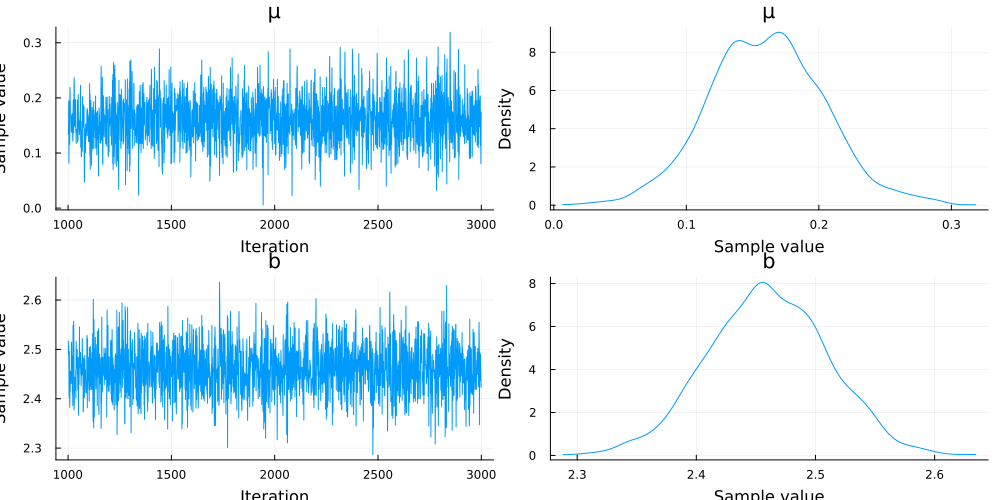

In [14]:
# To learn the Laplace distribution:
chain_laplace = learn_distribution_mcmc(LaplaceModel(), Rᵢ);

plot(chain_laplace)


Finally, we will prepare all of our fitted models for a head-to-head comparison. We will use the traditional **Maximum Likelihood Estimation (MLE)** to fit a Laplace distribution as a baseline. Then, we will bring together all the models—both MCMC and MLE—for a final comparison using visual plots and quantitative statistics.

In [15]:
# --- Prepare All Four Models ---

# 1. MLE Model
Laplace_MLE = fit_mle(Laplace, Rᵢ);

# 2. MCMC Models 
μ_t_mean = mean(chain_t[:μ])
σ_t_mean = mean(chain_t[:σ])
ν_t_mean = mean(chain_t[:ν])
StudentT_MCMC = LocationScale(μ_t_mean, σ_t_mean, TDist(ν_t_mean))

μ_laplace_mean = mean(chain_laplace[:μ])
b_laplace_mean = mean(chain_laplace[:b])
Laplace_MCMC = Laplace(μ_laplace_mean, b_laplace_mean);


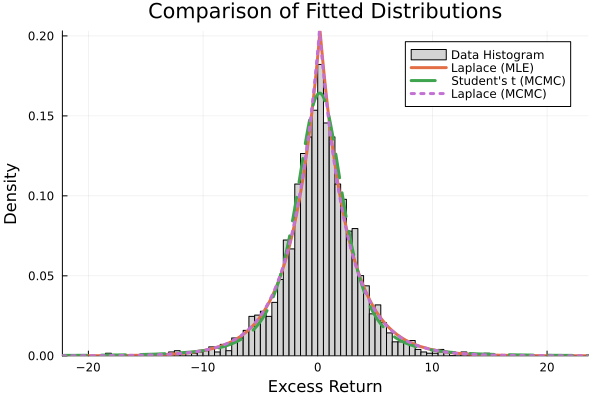

In [16]:
# --- UPDATED: Visual Comparison of Four Distributions ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=100, label="Data Histogram", c=:lightgray)

# Plot the four models
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)")
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", ls=:dash)
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", ls=:dot)

title!("Comparison of Fitted Distributions")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

In [17]:
# --- UPDATED: Quantitative Comparison of Four Distributions ---

# A. Summary Statistics
println("--- Summary Statistics ---")
println("Laplace (MLE):")
println("  Mean:      ", mean(Laplace_MLE))
println("  Variance:  ", var(Laplace_MLE))
println("  Kurtosis:  ", kurtosis(Laplace_MLE))

println("\nStudent's t (MCMC):")
println("  Mean:      ", mean(StudentT_MCMC))
println("  Variance:  ", var(StudentT_MCMC))
println("  Kurtosis:  ", kurtosis(StudentT_MCMC))

println("\nLaplace (MCMC):")
println("  Mean:      ", mean(Laplace_MCMC))
println("  Variance:  ", var(Laplace_MCMC))
println("  Kurtosis:  ", kurtosis(Laplace_MCMC))


# B. AIC Comparison (Lower is Better)
log_like_L_MLE = loglikelihood(Laplace_MLE, Rᵢ)
log_like_T_MCMC = loglikelihood(StudentT_MCMC, Rᵢ)
log_like_L_MCMC = loglikelihood(Laplace_MCMC, Rᵢ)

aic_L_MLE = 2*2 - 2*log_like_L_MLE
aic_T_MCMC = 2*3 - 2*log_like_T_MCMC
aic_L_MCMC = 2*2 - 2*log_like_L_MCMC

println("\n--- Model Comparison (Lower AIC is Better) ---")
println("AIC for Laplace (MLE):       ", aic_L_MLE)
println("AIC for Laplace (MCMC):      ", aic_L_MCMC)
println("AIC for Student's t (MCMC):  ", aic_T_MCMC)

--- Summary Statistics ---
Laplace (MLE):
  Mean:      0.20271168240401155
  Variance:  12.094928677932293
  Kurtosis:  3.0

Student's t (MCMC):
  Mean:      0.1706208592930424
  Variance:  24.336085109910137
  Kurtosis:  Inf

Laplace (MCMC):
  Mean:      0.16016753734127906
  Variance:  12.102663572450668
  Kurtosis:  3.0

--- Model Comparison (Lower AIC is Better) ---
AIC for Laplace (MLE):       13041.436637444162
AIC for Laplace (MCMC):      13042.091779589966
AIC for Student's t (MCMC):  13066.793347423587


In [18]:
# Choose one of these to be your distribution in the variable d that will be used for generating CDF

d = StudentT_MCMC;

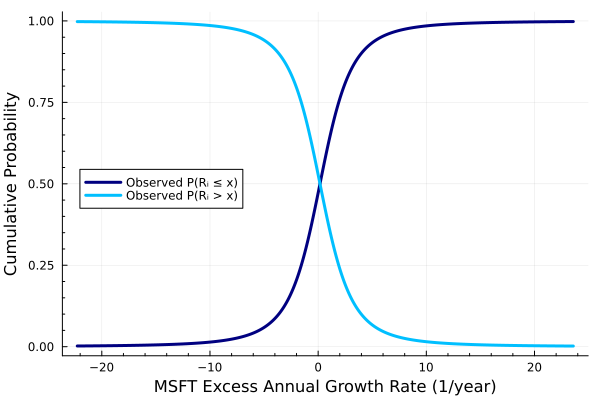

In [19]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)

        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="Observed P(Rᵢ ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="Observed P(Rᵢ > x)", legend=:left)

    xlabel!("$(ticker) Excess Annual Growth Rate (1/year)", fontsize=18);
    ylabel!("Cumulative Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [20]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect

81-element Vector{Float64}:
 0.0
 0.0125
 0.025
 0.0375
 0.05
 0.0625
 0.075
 0.0875
 0.1
 0.1125
 0.125
 0.1375
 0.15
 ⋮
 0.8625
 0.875
 0.8875
 0.9
 0.9125
 0.925
 0.9375
 0.95
 0.9625
 0.975
 0.9875
 1.0

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x`
for which `cdf(d, x) ≥ q`.

In [21]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

80×3 Matrix{Float64}:
 -Inf       -10.5513    1.0
 -10.5513    -7.7079    2.0
  -7.7079    -6.33639   3.0
  -6.33639   -5.4668    4.0
  -5.4668    -4.84218   5.0
  -4.84218   -4.35979   6.0
  -4.35979   -3.96906   7.0
  -3.96906   -3.64173   8.0
  -3.64173   -3.36051   9.0
  -3.36051   -3.11413  10.0
  -3.11413   -2.89486  11.0
  -2.89486   -2.69721  12.0
  -2.69721   -2.51711  13.0
   ⋮                   
   3.03845    3.2361   69.0
   3.2361     3.45537  70.0
   3.45537    3.70175  71.0
   3.70175    3.98297  72.0
   3.98297    4.3103   73.0
   4.3103     4.70103  74.0
   4.70103    5.18343  75.0
   5.18343    5.80805  76.0
   5.80805    6.67763  77.0
   6.67763    8.04915  78.0
   8.04915   10.8925   79.0
  10.8925    Inf       80.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [22]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample

2514-element Vector{Int64}:
  7
 45
  8
 19
 66
  6
 59
 78
 43
 26
 22
 17
 42
  ⋮
 51
  6
 60
 52
 42
 45
 32
 55
 40
 30
 52
 41

This cell can be used to check the density of a certain hidden state.

In [23]:
let
state_density = [value for value in encoded_in_sample if value == 23]
end;

Find the state most frequently repeated. 

In [24]:
let 
# Create a map of states to their counts
counts = countmap(encoded_in_sample)

# Find the state with the maximum count
most_frequent_state = argmax(counts)
end;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [25]:
T = zeros(number_of_states, number_of_states)
number_insample = length(encoded_in_sample);
for i ∈ 2:number_insample
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

80×80 Matrix{Float64}:
 2.0  1.0  2.0  2.0  0.0  0.0  1.0  0.0  …  1.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0     1.0  0.0  2.0  0.0  1.0  0.0  1.0
 1.0  2.0  1.0  1.0  3.0  2.0  0.0  2.0     0.0  0.0  0.0  1.0  0.0  1.0  1.0
 0.0  2.0  0.0  0.0  1.0  1.0  0.0  2.0     0.0  1.0  0.0  2.0  1.0  2.0  2.0
 1.0  4.0  1.0  1.0  2.0  1.0  0.0  0.0     0.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  2.0  1.0  0.0  0.0  …  0.0  1.0  0.0  0.0  1.0  2.0  0.0
 0.0  1.0  1.0  4.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0     0.0  2.0  1.0  0.0  0.0  1.0  2.0
 0.0  0.0  1.0  2.0  1.0  0.0  0.0  2.0     1.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  …  1.0  2.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  3.0  0.0  1.0     0.0  1.0  0.0  0.0  2.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  2.0  1.0  

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [26]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

80×80 Matrix{Float64}:
 0.111111   0.0555556  0.111111   …  0.0        0.0555556  0.0
 0.0344828  0.0344828  0.0344828     0.0344828  0.0        0.0344828
 0.0285714  0.0571429  0.0285714     0.0        0.0285714  0.0285714
 0.0        0.0434783  0.0           0.0217391  0.0434783  0.0434783
 0.025641   0.102564   0.025641      0.025641   0.025641   0.0
 0.0        0.0        0.030303   …  0.030303   0.0606061  0.0
 0.0        0.0384615  0.0384615     0.0        0.0        0.0
 0.0        0.0        0.0357143     0.0357143  0.0        0.0
 0.0        0.0357143  0.0357143     0.0        0.0357143  0.0714286
 0.0        0.0        0.0322581     0.0322581  0.0        0.0
 0.04       0.0        0.04       …  0.0        0.0        0.0
 0.0238095  0.0        0.0           0.047619   0.0        0.0
 0.0        0.0294118  0.0           0.0        0.0        0.0294118
 ⋮                                ⋱                        
 0.0        0.0512821  0.0           0.0        0.0        0.0
 0.0 

## Task 2: In-Sample Analysis of the Standard HMM
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [27]:
model = build(MyHiddenMarkovModel, (
    states = states,
    T = T̂,
    E = E
));

### Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [28]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # compute the stationary distribution (approx value is ok)

### Implement the `MARKOV-SIMULATION` pseudo code to generate hypothetical return sequences
Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array.`

In [29]:
number_of_steps = maximum_number_trading_days;
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

2515×100 Matrix{Int64}:
 11   6  26  30  21  28   4   6  74  …  26  41  24  60  43  72  66  24  31
 73  79  22  10  36   8  54  30  68     22  49  53  78  17  35  65  15  74
 31  47  19   4  47   3  77  40  55     66   6  20   4  74  39   2  61  68
 72  62  57  39  43   3   8  65  43     40  18  25  18  35   9   5  73  63
 26  63   6  29  58   2  39  50  69     30  12   7  23  29  75  72  31  72
 26  43  29  30  68  61  31  37  20  …  20  16  45  10   4  53  52  11  18
 21  57  37  28  55  50  27  47  72     72  51   4  38  63  65  31   7  36
 48  18  76  13  28  36  29  68  62     31   8  31  51  66  71  78  10  63
 30  75  37  70  29  29   4  63  39     53  51   8   8  60  52   4   5  42
 40   7   3   7  60  70  47  39   3     35  32   3  49  46  52  78  56  68
 39  62   2  47  55  69  52  64   5  …   7   8  18  73   2  26  62   8  50
 28  43  17  69  21  70  42   4  36     53  59  32  30  19  69  69  36  26
 55  69  58  67  43  48  10  13  20     55  30  75   2  52  56  44  51  70
 

In [30]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

80×3 Matrix{Float64}:
 -22.2675   -10.5513    1.0
 -10.5513    -7.7079    2.0
  -7.7079    -6.33639   3.0
  -6.33639   -5.4668    4.0
  -5.4668    -4.84218   5.0
  -4.84218   -4.35979   6.0
  -4.35979   -3.96906   7.0
  -3.96906   -3.64173   8.0
  -3.64173   -3.36051   9.0
  -3.36051   -3.11413  10.0
  -3.11413   -2.89486  11.0
  -2.89486   -2.69721  12.0
  -2.69721   -2.51711  13.0
   ⋮                   
   3.03845    3.2361   69.0
   3.2361     3.45537  70.0
   3.45537    3.70175  71.0
   3.70175    3.98297  72.0
   3.98297    4.3103   73.0
   4.3103     4.70103  74.0
   4.70103    5.18343  75.0
   5.18343    5.80805  76.0
   5.80805    6.67763  77.0
   6.67763    8.04915  78.0
   8.04915   10.8925   79.0
  10.8925    23.5874   80.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [31]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [32]:
in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
in_sample_decoded_archive # actual excess growth value

2515×100 Matrix{Float64}:
 -3.03832    -4.81743   -1.012       …    2.53601    -1.23452   -0.543565
  4.03749     9.17521   -1.43172          2.39332    -2.27873    4.46844
 -0.58407     0.664513  -1.73051        -10.555       1.97791    2.93211
  3.83333     2.04272    1.54836         -4.89239     4.11689    2.17339
 -1.00029     2.20875   -4.61589          3.92953    -0.596213   3.79646
 -1.04164     0.38005   -0.706456    …    1.04385    -2.98903   -1.85621
 -1.5523      1.55561   -0.0749663       -0.567195   -4.12821   -0.141406
  0.739334   -1.87159    5.3167           6.88174    -3.21352    2.23036
 -0.648301    5.06334   -0.0808234       -5.92349    -5.23851    0.279295
  0.135794   -4.05647   -6.88753          7.35385     1.42913    2.90077
  0.0589253   2.09991   -8.53633     …    2.07304    -3.80696    0.892142
 -0.83966     0.377685  -1.92455          3.02826    -0.1318    -1.01118
  1.36852     3.17465    1.67116          0.458666    0.990642   3.3342
  ⋮                   

### Visualize an example in-sample return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data.

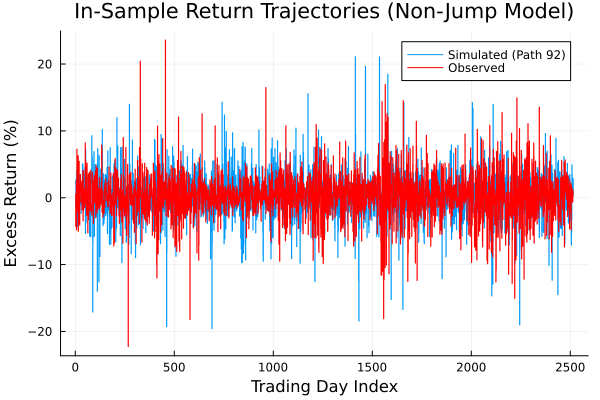

In [50]:
let
    # Select a random path to plot, just like in your working example
    index_to_plot = rand(1:number_of_paths)

    # Plot the SIMULATED data first, creating the plot
    plot(in_sample_decoded_archive[:, index_to_plot], linetype=:steppost, label="Simulated (Path $(index_to_plot))")

    # Add the OBSERVED data to the plot, slicing it to match the simulation length
    plot!(in_sample_dataset[1:(number_of_steps - 1)], linetype=:steppost, c=:red, label="Observed")
    
    # Add labels and a title
    xlabel!("Trading Day Index")
    ylabel!("Excess Return (%)")
    title!("In-Sample Return Trajectories (Non-Jump Model)")
end

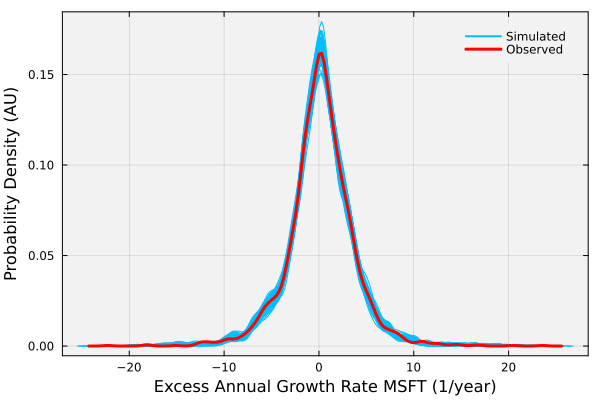

In [34]:
let
    q = plot();
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted and observed in-sample distributions the same?
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution):

In [35]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0195884

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7203

Details:
    number of observations:   [2514,2515]
    KS-statistic:              0.6945612896996498


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [36]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 99.0%


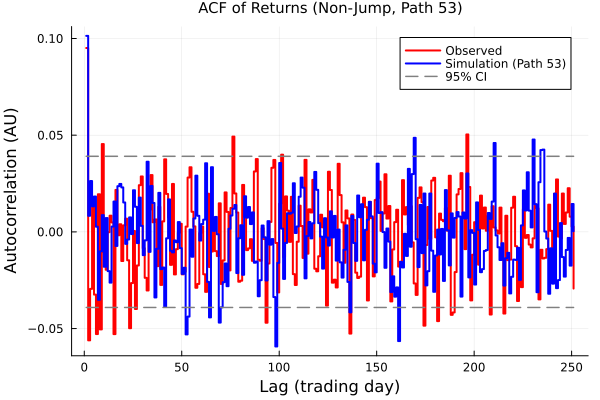

In [37]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of Returns (Non-Jump, Path $(random_index))", random_index)
end

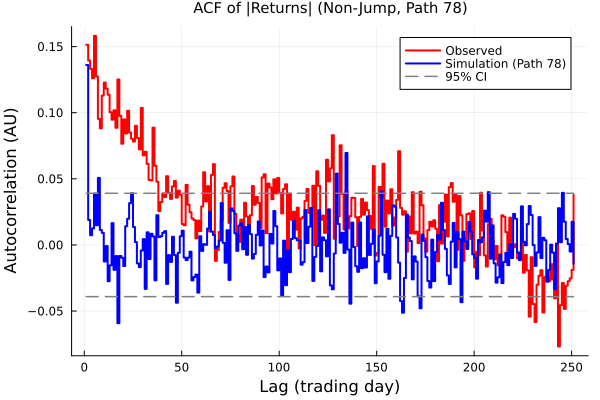

In [38]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of |Returns| (Non-Jump, Path $(random_index))", random_index, is_absolute=true)
end

### Conclusion from the Non-Jump Model Analysis

The autocorrelation plots reveal a key insight:
* **Success:** The standard HMM successfully replicates the lack of significant autocorrelation in raw returns, consistent with the efficient market hypothesis.
* **Failure:** The model completely fails to reproduce the strong, persistent autocorrelation in **absolute returns**. This means the simple HMM **cannot capture volatility clustering**, a critical stylized fact of financial markets.

This failure motivates the need for a more sophisticated model, which we explore in Task 4.

## Task 3: Can a Jump Model Reproduce Volatility Clustering?

Having established the primary weakness of the standard HMM, we now test if the modified model that includes price jumps can address this shortcoming. We will run the same autocorrelation analysis on the jump model's output to directly compare its ability to generate realistic volatility clustering.

In this task, we test if a modified Markov model that includes price jumps can address the shortcomings of the simple HMM. We will run the same autocorrelation analysis on the jump model's output to directly compare its ability to generate realistic volatility clustering.
Suppose every so often, instead of transitioning to the next state by sampling the transition matrix, we jump to a __tail state__ of the cumulative distribution. We then stay in one of the tail states for a random number of steps, governed by a [Possion distribution](https://en.wikipedia.org/wiki/Poisson_distribution).

To explore this idea, we built [a `MyHiddenMarkovModelWithJumps` instance](src/Types.jl), which holds the same data as the non-jump model. However, we now have two new parameters: the `ϵ::Float64` parameter controls the frequency with which we observe jumps, and the `λ::Int64` parameter is the mean number of events that occur in a given time frame.

We save this model in the `jump_model::MyHiddenMarkovModelWithJumps` variable

In [39]:
jump_model = let

    model = build(MyHiddenMarkovModelWithJumps, (
        states = states,
        T = T̂,
        E = E,
        ϵ = 0.0001, # fraction of steps that we have a jump event
        λ = 63, # mean number of jump events
    ));

    model;
end;

__Sample__: Next, we sample the `jump_model::MyHiddenMarkovModelWithJumps` model. Sampling the model results in the `encoded_archive_with_jumps::Array{Float64,2}` array, which holds sample paths (alternative futures) on the columns and time steps on the rows.

In [40]:
encoded_archive_with_jumps = let
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);

        @show i

        tmp = jump_model(start_state, number_of_steps)
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j]
        end
    end
    encoded_archive
end;

i = 1
i = 2
i = 3
i = 4
number_of_jumps = 71
i = 5
i = 6
i = 7
i = 8
i = 9
number_of_jumps = 44
i = 10
i = 11
number_of_jumps = 63
i = 12
i = 13
number_of_jumps = 60
i = 14
number_of_jumps = 65
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
number_of_jumps = 62
i = 22
i = 23
i = 24
i = 25
number_of_jumps = 65
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
number_of_jumps = 78
number_of_jumps = 57
i = 41
number_of_jumps = 68
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
number_of_jumps = 62
i = 51
number_of_jumps = 67
i = 52
i = 53
i = 54
number_of_jumps = 57
i = 55
i = 56
number_of_jumps = 62
i = 57
i = 58
i = 59
i = 60
number_of_jumps = 75
number_of_jumps = 51
i = 61
number_of_jumps = 63
i = 62
i = 63
i = 64
i = 65
i = 66
number_of_jumps = 70
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
number_of_jumps = 56
i = 77
i = 78
i = 79
i = 80
i = 81
number_of_jumps = 51
i = 82
i = 83
i = 84
n

__Decode__: We then decode the encoded states and save the decoded values in the `in_sample_decoded_archive_with_jumps::Array{Float64,2}` array. Each row is a return value at the time step, while each column is a sample path, i.e., an alternative universe in which our process is running

In [41]:
in_sample_decoded_archive_with_jumps = let
    in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive_with_jumps[j,i];
            in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    in_sample_decoded_archive # actual excess growth value
end;

In [42]:
in_sample_decoded_archive_with_jumps

2515×100 Matrix{Float64}:
   0.0716008   2.15038   -1.18346    …  -3.40204   -0.0550241   -2.29506
  -2.27871     2.60895   -0.358227       3.42122    1.77335     -0.385016
  -2.14779     0.232166   1.39767        4.11058    0.719471     1.83981
   1.53959    -0.453228   1.3494         0.208362   3.98984      0.209845
  -1.50794     1.4326     1.83195        1.38222    0.236142    -1.43831
   0.653903    0.385613  -5.69754    …  -1.50056   -0.995473    -0.334611
   0.61095     0.299803  -1.51025        2.44894    1.72361      1.36618
  -1.4818     -2.4885     0.596252       3.55129   -4.11408     -0.163264
  -1.42228     1.42136    4.56237       -3.46733    0.893204    -1.52544
  -2.83471     5.11763   -0.273039      -5.23146   -0.398261     0.61238
   3.84271     1.86258   -3.14528    …   7.03078    1.81234      1.31417
   4.57141     3.10655    3.78794       -2.97871   -5.46916      0.0405351
  -1.1028      1.9787     5.54947        0.233113  -5.36088      0.714145
   ⋮              

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data. These simulated returns are generated using the jump model.

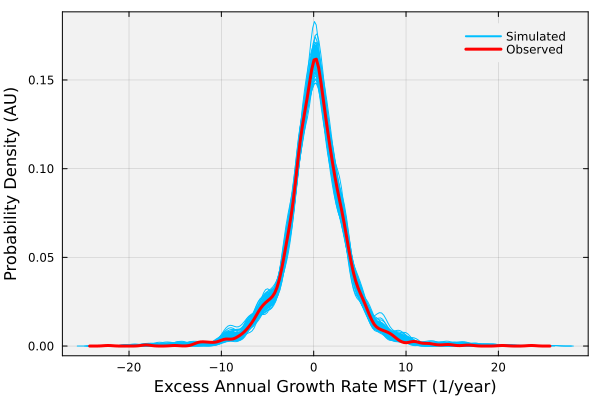

In [43]:
let
    q = plot();
    density!(in_sample_decoded_archive_with_jumps[:,1], lw=2, c=:deepskyblue1, label="Simulated",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive_with_jumps[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()

    # # Save the figure
    # savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ExcessGrowthRate-Probability-Density-HMM.svg"));

end


### Check: Are the predicted jump model returns and observed in-sample distributions the same?
If our jump Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our jump model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution):

In [44]:
let
    pvalue_cutoff = 0.05; # 95% cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 99.0%


### Visualize an example in-sample jump return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

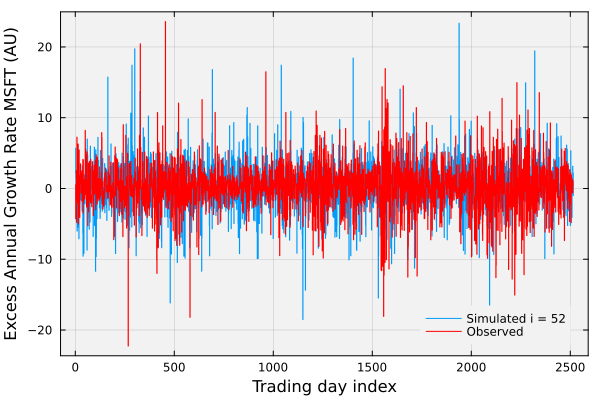

In [45]:
let
    index_to_plot = 52 # or rand(1:number_of_paths);
    plot(in_sample_decoded_archive_with_jumps[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset[1:(number_of_steps-1)], linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)

    # # dump
     # savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ExcessGrowthRate-in-sample-Trajectory-Daily-HMM.svg"))
end

### Stylized facts for in-sample dataset
This task compares the stylized facts for the observed insample and simulated excess growth datasets. In particular, we'll look at two stylized facts, namely, the autocorrelation of the excess growth rate and the volatility clustering, i.e., the autocorrelation of the absolute value of the excess growth rate.

### Lack of Autocorrelation of Returns

First, we test a key stylized fact derived from the [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis): the autocorrelation of raw returns should be statistically insignificant for all lags. A model that successfully captures market behavior should be able to reproduce this lack of linear predictability.

#### Summary of Findings
* The plot below compares the autocorrelation of the observed **in-sample** returns (`Rᵢ`) with a randomly selected simulation path.
* As expected, both the real-world data (red) and the simulated data (blue) show near-zero autocorrelation that lies mostly within the 95% confidence interval.
* This confirms that our model successfully captures this feature of the data.

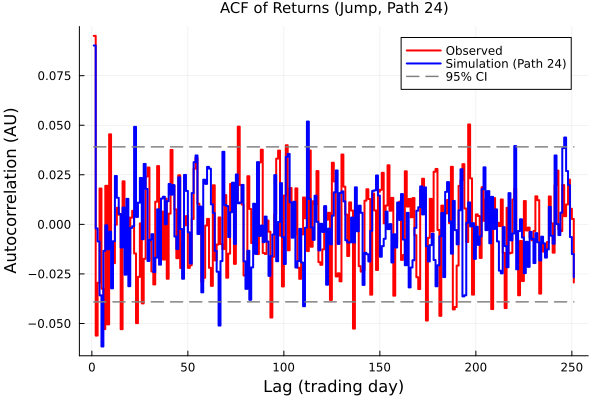

In [46]:
let
    random_index = rand(1:number_of_paths)
    simulated_path_jumps = in_sample_decoded_archive_with_jumps[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path_jumps, "ACF of Returns (Jump, Path $(random_index))", random_index)
end

### Volatility Clustering

Next, we examine a more complex stylized fact: **volatility clustering**. This is the tendency for large market movements (of either sign) to be followed by more large movements, and for calm periods to be followed by more calm periods. We test for this by analyzing the autocorrelation of the **absolute value** of the returns.

#### Summary of Findings
* The observed **in-sample** data (red line) shows positive and persistent autocorrelation in its absolute returns. This is the classic signature of volatility clustering.
* The plot below shows that the **Jump Markov model** (blue line) successfully replicates this pattern, demonstrating a significant improvement over a simple HMM. This confirms the jump component is crucial for capturing this key market dynamic.

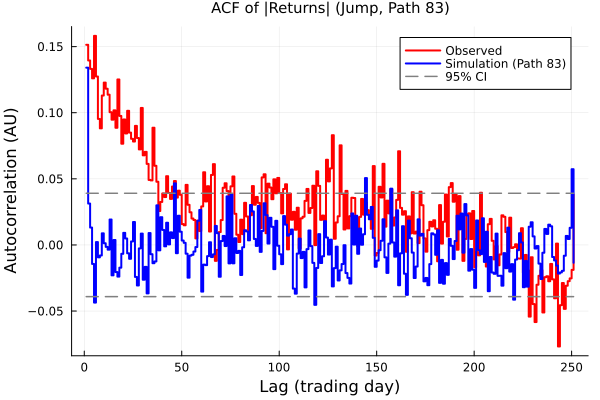

In [47]:
let
    random_index = 83 #rand(1:number_of_paths)
    simulated_path_jumps = in_sample_decoded_archive_with_jumps[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path_jumps, "ACF of |Returns| (Jump, Path $(random_index))", random_index, is_absolute=true)
end

## Task 4: Save the Model Artifacts
We'll use the hidden Markov Model (HMM) we developed here. Let's save the model to disk to save some time later on. Use the [save(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git) to write a [model file in HDF5 binary format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). First, we specify a `path` in the `path_to_save_file` variable:

In [48]:
#path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(ticker)-daily-aggregate.jld2");

Then we write an [`HDF5 binary file`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data to the location specified by `path_to_save_file.` We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use to the `load(...)` function to reload this data):

In [49]:
# save(path_to_save_file, Dict("model"=>model, "jump_model" => jump_model,
#         "decode"=>decode_distribution_model, "stationary"=>π̄,
#         "insampledataset"=>in_sample_dataset, "encoded_archive" => encoded_archive, "encoded_archive_with_jumps" => encoded_archive_with_jumps,
#         "in_sample_decoded_archive_with_jumps" => in_sample_decoded_archive_with_jumps,
#         "in_sample_decoded_archive" => in_sample_decoded_archive));

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.